In [1]:
import os 
import pandas as pd

final_df = pd.DataFrame(columns=['content', 'type'])

for x in os.listdir('car_nlp_csv'):
    a = pd.read_csv('car_nlp_csv//'+x)
    final_df = pd.concat([final_df, a], ignore_index = 1)

In [2]:
from sklearn.utils import shuffle
final_df = shuffle(final_df)
final_df

,content,type,Unnamed: 0
145096,PRIUS 安全性 召回 更新 注意 事項 大陸 台灣 發生數 更新 失敗 災情 起初 多數...,Toyota_prius,25185.0
138570,換心 進化 Toyota 小改款 Vios Yaris 試駕 舊版 加速 實測 Vios Y...,Toyota_vios,18659.0
60230,古董 一代 CRV 準備 進場 底盤 大修 可否 神人 開示 頭好 壯壯 17 一代 CRV...,Honda_crv,15552.0
117799,15 頻道 年度 飆榜 Subaru Forester 2.0 XS 登台 說真的 喜歡 參...,Subaru_impreza,2982.0
90540,變速箱 濾網 更換 價格 爬文 得知 原廠 並無此 保養 fortis1.8 快八萬 公里 ...,Mitsubishi_fortis,4228.0
...,...,...,...
114072,308 1.6 hdi 容易 開過 那麼多 部車 這一 部車 懊惱 3081.6 hdi 買...,Peugeot_308,517.0
62511,CRV 2.4 VTI 保險 乙式 自負額 竊盜 10% 意外 200 400 50 乘客 ...,Honda_crv,17833.0
108728,BIG TIIDA 南部 成交 3q 比單 私密 購車 1.6 五門 掀背 豪華版 售價 6...,Nissan_tiida,10074.0
104146,Sentra 180 BAS 料號 47210 YS000 Sentra 180N16air...,Nissan_sentra,5492.0


In [3]:
final_df.type.value_counts()

Ford_focus              13280
Toyota_altis            10817
Honda_civic              8147
Honda_crv                7951
VK_golf                  5795
Toyota_camry             4716
Toyota_rav4              4551
Nissan_livina            4422
Ford_mondeo              4362
Mitsubishi_lancer        4300
Ford_fiesta              4246
Honda_fit                4223
Ford_kuga                4157
Mazda_mazda3             4001
Nissan_tiida             3692
Mitsubishi_fortis        3552
Mitsubishi_outlander     3100
Honda_accord             2999
Volvo_s60                2655
Toyota_yaris             2613
Luxgen_u6                2573
Nissan_sentra            2482
Volvo_xc60               2331
Subaru_forester          2253
Hyundai_elantra          2176
Ford_escape              2120
BMW_320                  2075
BMW_520                  2058
Toyota_vios              2056
VK_tiguan                2038
Audi_a4                  1994
Nissan_teana             1940
Mazda_cx-5               1798
Subaru_leg

In [3]:
corpus = final_df['content'].tolist()

from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features = 1000)
X = cv.fit_transform(corpus).toarray()
Y = final_df['type'].tolist()

In [4]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
# encode class values as integers
encoder = LabelEncoder()
encoded_Y = encoder.fit_transform(Y)
# convert integers to dummy variables (one hot encoding)
dummy_y = np_utils.to_categorical(encoded_Y)

Using TensorFlow backend.


In [5]:
import numpy as np 
np.max(encoded_Y)

57

In [6]:
from sklearn.model_selection import train_test_split
# splitting data into training set and test set. If random_state is set to an integer, the split datasets are fixed.
X_train, X_test, Y_train, Y_test = train_test_split(X, dummy_y, test_size=0.2, random_state=42)


In [7]:
from keras.layers import Convolution1D, Flatten, Dropout, MaxPool1D, GlobalAveragePooling1D
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import  BatchNormalization
from keras.layers.embeddings import Embedding
from keras.models import Sequential
import numpy as np
vocab_size = np.max([np.max(X_train[i]) for i in range(X_train.shape[0])]) + 1  # 这里1 代表空格，其索引被认为是0。

model = Sequential()
model.add(Embedding(vocab_size, 300, input_length=1000))
model.add(Convolution1D(256, 3, padding='same'))
model.add(MaxPool1D(3,3,padding='same'))
model.add(Convolution1D(128, 3, padding='same'))
model.add(MaxPool1D(3,3,padding='same'))
model.add(Convolution1D(64, 3, padding='same'))
model.add(Flatten())
model.add(Dropout(0.1))
model.add(BatchNormalization()) # (批)规范化层
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(58,activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 300)         4500      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1000, 256)         230656    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 334, 256)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 334, 128)          98432     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 112, 128)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 112, 64)           24640     
_________________________________________________________________
flatten_1 (Flatten)          (None, 7168)             

In [8]:
from keras.optimizers import Adam
# Compile model
EPOCHS = 20
INIT_LR = 1e-3
BS = 100
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,
    metrics=["accuracy"])
from keras.callbacks import EarlyStopping, CSVLogger
estop = EarlyStopping(monitor='val_loss', patience=10)
logger = CSVLogger('model_textcnn0915.log')

In [10]:
H = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=20, batch_size=BS, callbacks=[logger])

C:\Users\Big data\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 130631 samples, validate on 32658 samples
Epoch 1/20
130631/130631 [==============================] - 221s 2ms/step - loss: 1.0578 - accuracy: 0.7014 - val_loss: 0.9477 - val_accuracy: 0.7353
Epoch 2/20
130631/130631 [==============================] - 218s 2ms/step - loss: 0.7542 - accuracy: 0.7616 - val_loss: 0.8733 - val_accuracy: 0.7305
Epoch 3/20
130631/130631 [==============================] - 218s 2ms/step - loss: 0.6812 - accuracy: 0.7763 - val_loss: 0.8831 - val_accuracy: 0.7348
Epoch 4/20
130631/130631 [==============================] - 218s 2ms/step - loss: 0.6142 - accuracy: 0.7912 - val_loss: 1.5143 - val_accuracy: 0.7142
Epoch 5/20
130631/130631 [==============================] - 218s 2ms/step - loss: 0.5605 - accuracy: 0.8033 - val_loss: 0.9246 - val_accuracy: 0.7280
Epoch 6/20
130631/130631 [==============================] - 218s 2ms/step - loss: 0.5077 - accuracy: 0.8166 - val_loss: 1.7919 - val_accuracy: 0.6915
Epoch 7/20
130631/130631 [=======================

In [23]:
model.save('car_nlp0910_3.h5')

In [29]:
del model 

In [24]:
import pickle
feature_path = 'models_dc0910_3.pkl'
with open(feature_path, 'wb') as fw:
    pickle.dump(cv.vocabulary_, fw)

In [25]:
from sklearn.preprocessing import LabelBinarizer
import pickle

lb = LabelBinarizer()
labels_copy = lb.fit_transform(Y)
with open('lb_nlp0910_3.pickle', 'wb') as f:
    f.write(pickle.dumps(lb))

ValueError: x and y must have same first dimension, but have shapes (10,) and (20,)

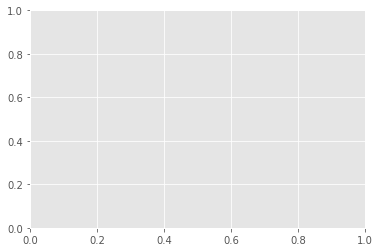

In [26]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.figure()
N = EPOCHS
plt.plot(np.arange(0,N), H.history['loss'], label = 'train_loss')
plt.plot(np.arange(0,N), H.history['val_loss'], label = 'val_loss')
plt.plot(np.arange(0,N), H.history['accuracy'], label = 'train_acc')
plt.plot(np.arange(0,N), H.history['val_accuracy'], label = 'val_acc')
plt.title('Training Loss and Accuracy on car-type-nlp classifier')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend(loc='lower left')
plt.savefig('car-type-nlp3.png')

In [27]:
c = {'content':abc, 'type':Y}

In [28]:
final_df_tags = pd.DataFrame(c)
final_df_tags

,content,type
0,NO 特仕車 配備 倒車 油電 系統 置物 LC CAMRY 室內 顯影 自動 收鏡 LE ...,Toyota_camry
1,聲音 RAV4 高興 異音 小聲 技師 不平 路面 先進 牽來 擾人 後門 關門 備胎 外殼...,Toyota_rav4
2,記憶 副駕 調整 後座 這就 S60 副駕駛 駕駛 要載 位置 椅子 功能 座椅 常常 三組...,Volvo_s60
3,順益 經銷商 價格 匯豐 裕益 折價 09 領牌 服務 lanceriO 出廠 想問 這三家...,Mitsubishi_lancer
4,系統 定速 油門 接手 暴衝 自動 速度 購入 2011 focus 1.84 10 跑國 ...,Ford_focus
...,...,...
163284,V60 316 配備 BMW 導航 價格 系統 二手價 S60 Volvo 選配 豪華 不錯...,Volvo_v60
163285,C300 行燈 XD 2011 旅行車 渦輪 不錯 霧燈 引擎 開箱 ES 馬力 腳踏墊 牽...,Benz_c200
163286,顯示器 抬頭 車美仕 Toyota 幫忙 鑑定 說明書 授權 原廠 汽車 兩光 生產 Alt...,Toyota_altis
163287,更換 車門 保險 零件 LIVINA 舊品 賠償 主張 簡單 折舊 經濟 拍照 修復 價格 ...,Nissan_livina


In [29]:
final_df_tags.to_csv('final_df_tags.csv')

In [14]:
import jieba.analyse
corpus = final_df['content'].tolist()

In [15]:
abc = []
for x in corpus:
    c = " ".join(jieba.analyse.extract_tags(x, topK=100))
    abc.append(c)
    
    

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\BIGDAT~1\AppData\Local\Temp\jieba.cache
Loading model cost 0.493 seconds.
Prefix dict has been built successfully.


In [46]:
test = pd.DataFrame(abc, columns=['content'])

In [48]:
test.to_csv('abc.csv')

In [1]:
import pandas as pd
df = pd.read_csv('final_df_tags.csv')
corpus = df['content'].tolist()
Y = df['type'].tolist()

In [2]:
a = []
for x in corpus:
    a.append(x.split(' '))

In [3]:
from sklearn.model_selection import train_test_split
# splitting data into training set and test set. If random_state is set to an integer, the split datasets are fixed.
X_train, X_test, Y_train, Y_test = train_test_split(a, Y, test_size=0.2, random_state=42)

In [ ]:
import kashgari
from kashgari.tasks.classification import CNN_LSTM_Model
from tensorflow.keras.callbacks import TensorBoard
kashgari.config.use_cudnn_cell = True
import logging
logging.basicConfig(level='DEBUG')

tf_board = TensorBoard(log_dir='tf_dir/cnn_model',
                       histogram_freq=5, 
                       update_freq='batch')

model = CNN_LSTM_Model()
model.fit(X_train, Y_train,  X_test,Y_test,epochs=3, callbacks=[tf_board])


Preparing text vocab dict: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32658/32658 [00:00<00:00, 37755.34it/s]
2020-09-11 18:14:12,930 [DEBUG] kashgari - --- Build vocab dict finished, Total: 139663 ---
2020-09-11 18:14:12,931 [DEBUG] kashgari - Top-10: ['[PAD]', '[UNK]', '[CLS]', '[SEP]', '原廠', '不錯', '配備', '價格', '台灣', '10']
Calculating sequence length: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32658/32658 [00:00<00:00, 1088808.71it/s]
2020-09-11 18:14:13,926 [DEBUG] kashgari - Calculated sequence length = 100
2020-09-11 18:14:14,278 [DEBUG] kashgari - Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, None)]            0         
_________________________________________________________________
layer_em

Epoch 1/3
2041/2041 [==============================] - 216s 106ms/step - loss: 2.5660 - accuracy: 0.2751 - val_loss: 1.3636 - val_accuracy: 0.5392
Epoch 2/3
2041/2041 [==============================] - 216s 106ms/step - loss: 0.9198 - accuracy: 0.7046 - val_loss: 0.7300 - val_accuracy: 0.7751
Epoch 3/3
1715/2041 [========================>.....] - ETA: 33s - loss: 0.5579 - accuracy: 0.8212

In [35]:
model.save('model')

UnicodeEncodeError: 'cp950' codec can't encode character '\u6ca1' in position 249266: illegal multibyte sequence

In [12]:
model.evaluate(X_test,Y_test)

2020-09-11 13:30:33,276 [WARNING] kashgari - Sequence length is None, will use the max length of the samples, which is 93155
2020-09-11 13:31:45,771 [DEBUG] kashgari - predict input shape (32658, 93155) x: 
[[     2   1602    129 ...      0      0      0]
 [     2     56    251 ...      0      0      0]
 [     2   2497     36 ...      0      0      0]
 ...
 [     2   2633   2813 ...      0      0      0]
 [     2 132346 145614 ...      0      0      0]
 [     2    668   4860 ...      0      0      0]]


ResourceExhaustedError:  [_Derived_]  OOM when allocating tensor with shape[32,93155,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node cond/then/_0/CudnnRNNV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[model_1/bidirectional/backward_lstm/StatefulPartitionedCall]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_predict_function_160528]

Function call stack:
predict_function -> predict_function -> predict_function


In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, encoded_Y, test_size = 0.20, random_state = 42)


In [6]:
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [5]:
y_pred = classifier.predict(X_test)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

In [6]:
cm

array([[ 32,   2,  19, ...,  46,   0,   0],
       [ 16,   2,  49, ...,  98,   3,   0],
       [ 11,   2,  35, ...,  15,   2,   0],
       ...,
       [  0,   0,   2, ..., 124,   4,   0],
       [  0,   0,   0, ..., 131,  75,   7],
       [  0,   0,   1, ..., 269,  98,  19]], dtype=int64)

In [7]:
classifier.score(y_test, y_pred)

ValueError: Expected 2D array, got 1D array instead:
array=[ 2 20 25 ... 45 50 55].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [8]:
from sklearn.metrics.classification import accuracy_score
accuracy_score(y_test, y_pred)

C:\Users\Big data\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


0.17891481413436217

In [10]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0 )
classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [10]:
y_pred = classifier.predict(X_test)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

In [11]:
cm

array([[118,  47,  22, ...,   0,   1,   1],
       [ 32, 235,  34, ...,   0,   1,   2],
       [ 12,  40, 111, ...,   0,   0,   2],
       ...,
       [  1,   3,   0, ...,  48,  14,  35],
       [  0,   0,   0, ...,   5, 126,  49],
       [  0,   0,   0, ...,  13,  45, 380]], dtype=int64)

In [12]:
from sklearn.metrics.classification import accuracy_score
accuracy_score(y_test, y_pred)

0.6573274542225488

In [13]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'rbf', random_state = 0)
classifier.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)

In [14]:
y_pred = classifier.predict(X_test)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

In [15]:
from sklearn.metrics.classification import accuracy_score
accuracy_score(y_test, y_pred)

0.7349194684303999

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features = 1000)
X = cv.fit_transform(corpus).toarray()
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
# encode class values as integers
encoder = LabelEncoder()
encoded_Y = encoder.fit_transform(Y)

Using TensorFlow backend.


In [11]:
import pickle #pickle模組

#儲存Model(注:save資料夾要預先建立，否則會報錯)
with open('clf_rf.pickle', 'wb') as f:
    pickle.dump(classifier, f)

#讀取Model
# with open('clf.pickle', 'rb') as f:
#     clf2 = pickle.load(f)
#     #測試讀取後的Model
#     print(clf2.predict(X[0:1]))

In [30]:
s = ['阿福 課程 畢業 換車 預計 幫出 20 30 剩下 預算 90 60 區間 沒車 決定 幫家裡 90 安全 妥善 空間 喜歡 Toyota 討厭 Honda 雙田 mazda3 sx4']
word = cv.transform(s).toarray()

In [31]:
classifier.predict(word)

array([28], dtype=int64)

In [34]:
encoder.inverse_transform(classifier.predict(word))

'Mazda_mazda3'

In [8]:
with open('clf_nb_label.pickle', 'wb') as f:
    pickle.dump(encoder, f)

In [9]:
feature_path = 'nb_vc.pkl'
with open(feature_path, 'wb') as fw:
    pickle.dump(cv.vocabulary_, fw)

In [15]:
corpus[56]

'車窗 鑰匙 升降 斷電 電動 電力 功能 2010 Altis 1.8 還可以 先進 供電 買來 拔完 車門 開門 狀態 CAMRY 手冊 啟動 開啟 熄火 印象 停好 英文字 轉到 還得 開個 來關 剛滿 無意 順路 原廠 問了 服務 上來 這款 關著 試過 關門 TOYOTA 車是 翻閱 防盜 後照鏡 收折 鎖住 透氣 忘記 短暫 重複 電門 夜間 車庫 時關 一分鐘 自動 沒測過 按鈕 車型 yaris 適合 設定 42 內且 副駕駛座 門皆 馬上 喜歡 掙扎 說明 閱讀 注意到 解答 拔出 永久 提醒 竟然 回去 位置 一年 代表'

In [14]:
Y[56]

'Toyota_altis'

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
cv = TfidfVectorizer(max_features=10000)


In [3]:
X = cv.fit_transform(corpus).toarray()

In [13]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
#加载numpy的数组到DMatrix对象
xg_train = xgb.DMatrix(X_train, label=y_train)
xg_test = xgb.DMatrix( X_test, label=y_test)
#1.训练模型
# setup parameters for xgboost
param = {}
# use softmax multi-class classification
param['objective'] = 'multi:softmax'
# scale weight of positive examples
param['eta'] = 0.1
param['max_depth'] = 6
param['silent'] = 1
param['nthread'] = 4
param['num_class'] = 58

watchlist = [ (xg_train,'train'), (xg_test, 'test') ]
num_round = 6
bst = xgb.train(param, xg_train, num_round, watchlist )

pred = bst.predict( xg_test )
print ('predicting, classification error=%f' % (sum( int(pred[i]) != y_test[i] for i in range(len(y_test))) / float(len(y_test)) ))

[14:23:53] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-merror:0.20131	test-merror:0.22197
[1]	train-merror:0.19265	test-merror:0.21796
[2]	train-merror:0.18734	test-merror:0.21554
[3]	train-merror:0.18395	test-merror:0.21407
[4]	train-merror:0.18049	test-merror:0.21257
[5]	train-merror:0.17748	test-merror:0.21162
predicting, classification error=0.211617


In [14]:
# 14:22
import time
print(time.time())

1600154667.100448


In [15]:
pred

array([ 2., 20., 25., ..., 45., 50., 55.], dtype=float32)

In [17]:
y_test[0]

2

In [18]:
from sklearn.metrics.classification import accuracy_score
accuracy_score(y_test, pred)

C:\Users\Big data\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


0.7883826321268909

In [19]:
bst.save_model('xgboost_model0915.model')

In [21]:
bst2 = xgb.Booster(model_file='xgboost_model0915.model')

In [26]:
bst2.predict(xg_test)

array([ 2., 20., 25., ..., 45., 50., 55.], dtype=float32)

In [24]:
xg_test

In [25]:
import pickle #pickle模組

#儲存Model(注:save資料夾要預先建立，否則會報錯)
with open('bst.pickle', 'wb') as f:
    pickle.dump(bst, f)